# About

On previous notebooks we explore the data and we got into the conclusion that the size of the buildings is similar to the desired cell size of the cells to calculate stats (10x10m). This means that found the fraction of the building that match for each cell is critical to avoid no sense average values or assume that a building is only in one cell. 

On this notebook we will start defining the cells and assigning the buildings to the corresponding cells using some kind of geometry tools.

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import Polygon
import seaborn as sns

from tqdm import tqdm
tqdm.pandas()

In [2]:
# We load the testing data that belows to the city center (maybe we need to test later one outside the city center region where the data is not so dense)

data_folder = "Data/"
filename = "95b_buildings_target.csv"
#filename = "95b_buildings.csv"


geo_data = gpd.read_file(data_folder + filename)
geo_data['geometry'] = geo_data['geometry'].progress_apply(wkt.loads)
gdf = gpd.GeoDataFrame(geo_data, geometry='geometry')
gdf

100%|██████████| 9632/9632 [00:00<00:00, 92359.11it/s]


,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code
0,-34.6097565,-58.37273245,137.163,0.7771,"POLYGON ((-58.37269 -34.60983, -58.37269 -34.6...",48Q39JRG+3WRP
1,-34.60331185,-58.3882907,23.7655,0.6978,"POLYGON ((-58.38826 -34.60333, -58.38827 -34.6...",48Q39JW6+MMGG
2,-34.60667276,-58.38346319,214.7212,0.7673,"POLYGON ((-58.38343 -34.60678, -58.38343 -34.6...",48Q39JV8+8JM2
3,-34.606241,-58.37975464,218.6224,0.8731,"POLYGON ((-58.37969 -34.60634, -58.37972 -34.6...",48Q39JVC+G359
4,-34.60178779,-58.37226492,140.948,0.7562,"POLYGON ((-58.37218 -34.60183, -58.37219 -34.6...",48Q39JXH+73QG
...,...,...,...,...,...,...
9627,-34.61269145,-58.3782846,99.3895,0.8269,"POLYGON ((-58.37821 -34.61272, -58.37821 -34.6...",48Q39JPC+WMG9
9628,-34.59822428,-58.38798104,197.2301,0.7845,"POLYGON ((-58.38791 -34.59828, -58.38792 -34.5...",48Q3CJ26+PR64
9629,-34.60083266,-58.38025767,37.6236,0.662,"POLYGON ((-58.38022 -34.60086, -58.38023 -34.6...",48Q39JX9+MV9Q
9630,-34.61161837,-58.38908894,76.9883,0.7808,"POLYGON ((-58.38903 -34.61165, -58.38903 -34.6...",48Q39JQ6+9936


In [3]:
gdf.dtypes # We need to convert the not 'geometry' columns dtypes

latitude            object
longitude           object
area_in_meters      object
confidence          object
geometry          geometry
full_plus_code      object
dtype: object

In [4]:
gdf["latitude"] = gdf["latitude"].astype(float)
gdf["longitude"] = gdf["longitude"].astype(float)
gdf["confidence"] = gdf["confidence"].astype(float)
gdf["area_in_meters"] = gdf["area_in_meters"].astype(float)
gdf["full_plus_code"] = gdf["full_plus_code"].astype(str)
gdf.dtypes

latitude           float64
longitude          float64
area_in_meters     float64
confidence         float64
geometry          geometry
full_plus_code      object
dtype: object

<Axes: >

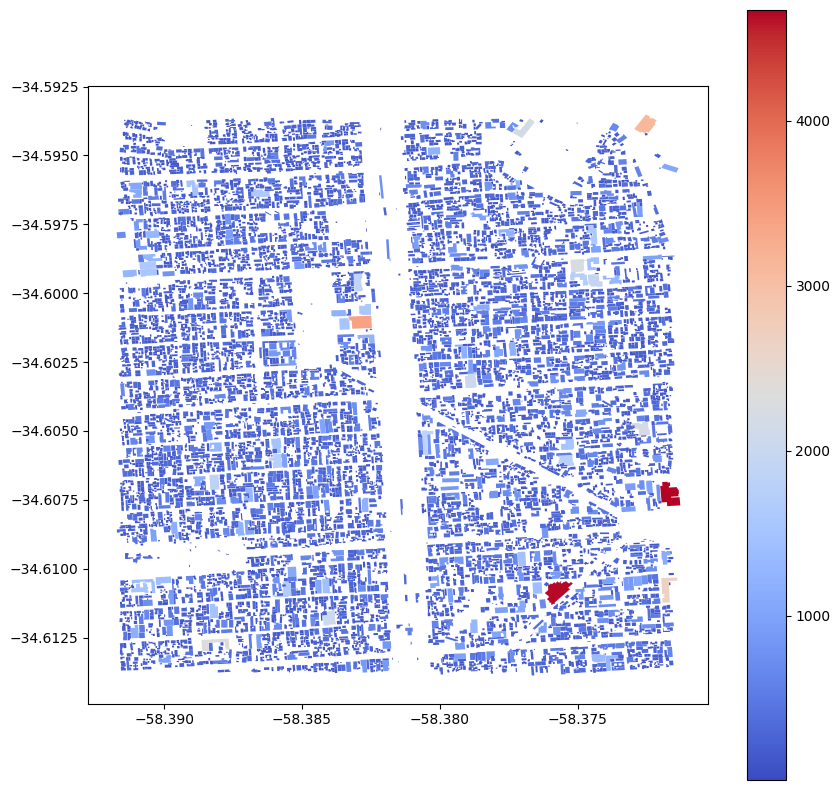

In [5]:
gdf.plot(column="area_in_meters", cmap="coolwarm", legend=True, figsize=(10, 10))

# Cells creation

We will create a grid of 10x10m cells over the area of interest, then we need to assign the buildings to all the corresponding cells. In order to do this we will assume that teh building has a "radious" equal to the max distance to the centroid of the building and then we will check all cells that are inside this radious. We will iterate over buildings because the cells are defined a priori, so we don't need to iterate over cells.



In [6]:
cell_size = 10 # 10 meters
cell_size_in_degrees = cell_size / 111320 # 1 degree is approximately 111.32 km

# We will create a naive long and lat coordinates relative to the center of the area that we want to analyze, this allows us to make easy the math to locate the corresponding cell with just a simple division.

area_center_lat = (gdf["latitude"].max() + gdf["latitude"].min()) / 2
area_center_lon = (gdf["longitude"].max() + gdf["longitude"].min()) / 2
gdf["relative_lat"] = gdf["latitude"] - area_center_lat
gdf["relative_lon"] = gdf["longitude"] - area_center_lon


# Now we could assign each building center to a coordinate pair on the grid just dividing the relative coordinates by the cell size in degrees and rounding down to the nearest integer

gdf["cell_lat"] = gdf["relative_lat"].floordiv(cell_size_in_degrees).astype(int)
gdf["cell_lon"] = gdf["relative_lon"].floordiv(cell_size_in_degrees).astype(int)

# We still need to know how much close cells could overlap with the building, so we will define the building size in terms of the cell size.

def calculate_polygon_size(polygon):
    # Calculate the size of the polygon in terms of the cell size
    min_x, min_y, max_x, max_y = polygon.bounds
    width = (max_x - min_x) / cell_size_in_degrees
    height = (max_y - min_y) / cell_size_in_degrees
    return max(width,height)/2

gdf["cells_size"] = gdf["geometry"].apply(calculate_polygon_size).astype(int) + 1 # We make +1 because we need to include at least one cell on each side in case that the building is close to the cell border. For example, in the case that the size (that is the max radius) is 0.79 cells, that means that we need to check all contiguous cells. In the case that the radius is 1.2 we need to check at least 2 cells on each side (and corners) because if the building center is very close to the cell border it could cross an entire cell on the side and reach the next one. 

gdf

,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code,relative_lat,relative_lon,cell_lat,cell_lon,cells_size
0,-34.609757,-58.372732,137.1630,0.7771,"POLYGON ((-58.37269 -34.60983, -58.37269 -34.6...",48Q39JRG+3WRP,-0.006034,0.008859,-68,98,1
1,-34.603312,-58.388291,23.7655,0.6978,"POLYGON ((-58.38826 -34.60333, -58.38827 -34.6...",48Q39JW6+MMGG,0.000411,-0.006699,4,-75,1
2,-34.606673,-58.383463,214.7212,0.7673,"POLYGON ((-58.38343 -34.60678, -58.38343 -34.6...",48Q39JV8+8JM2,-0.002950,-0.001872,-33,-21,2
3,-34.606241,-58.379755,218.6224,0.8731,"POLYGON ((-58.37969 -34.60634, -58.37972 -34.6...",48Q39JVC+G359,-0.002518,0.001837,-29,20,2
4,-34.601788,-58.372265,140.9480,0.7562,"POLYGON ((-58.37218 -34.60183, -58.37219 -34.6...",48Q39JXH+73QG,0.001935,0.009326,21,103,1
...,...,...,...,...,...,...,...,...,...,...,...
9627,-34.612691,-58.378285,99.3895,0.8269,"POLYGON ((-58.37821 -34.61272, -58.37821 -34.6...",48Q39JPC+WMG9,-0.008969,0.003307,-100,36,1
9628,-34.598224,-58.387981,197.2301,0.7845,"POLYGON ((-58.38791 -34.59828, -58.38792 -34.5...",48Q3CJ26+PR64,0.005499,-0.006390,61,-72,2
9629,-34.600833,-58.380258,37.6236,0.6620,"POLYGON ((-58.38022 -34.60086, -58.38023 -34.6...",48Q39JX9+MV9Q,0.002890,0.001334,32,14,1
9630,-34.611618,-58.389089,76.9883,0.7808,"POLYGON ((-58.38903 -34.61165, -58.38903 -34.6...",48Q39JQ6+9936,-0.007896,-0.007498,-88,-84,1


The advantage of this approach is that the scale of the calculations is O(n) because we will make just the calculations for each building independently of the size of the grid.

In [7]:
# Now we will create a grid of polygons where each grid cell is a square of size cell_size x cell_size to check the overlap within the objects

def create_polygon(x, y, cell_size_in_degrees, reference_x = 0, reference_y = 0):
    # Create a polygon for each cell
    coords = [(x, y), (x + 1, y), (x + 1, y + 1), (x, y + 1)]
    coords = [(coord[0] * cell_size_in_degrees + reference_x, coord[1] * cell_size_in_degrees + reference_y) for coord in coords]
    poly = Polygon(coords)
    return poly

def create_grid(x_min, x_max, y_min, y_max, cell_size_in_degrees, reference_x = 0, reference_y = 0):
    # Create a grid of polygons
    x_coords = list(range(x_min, x_max + 1))
    y_coords = list(range(y_min, y_max + 1))
    grid_polygons = {}
    for x in x_coords:
        grid_polygons[x] = {}
        for y in y_coords:
            # Create a polygon for each cell
            poly = create_polygon(x, y, cell_size_in_degrees, reference_x, reference_y)
            grid_polygons[x][y] = poly
    return grid_polygons



In [8]:
poly_grid = create_grid(gdf["cell_lon"].min(), gdf["cell_lon"].max(), gdf["cell_lat"].min(), gdf["cell_lat"].max(), cell_size_in_degrees, area_center_lon, area_center_lat)

In [9]:
def found_overlapping_cells(row, grid_polygons):
    # Get the cell coordinates
    cell_y = row["cell_lat"]
    cell_x = row["cell_lon"]
    cells_size = row["cells_size"]
    # Get the polygon
    polygon = row["geometry"]
    # Create a list to store the overlapping cells
    overlapping = []
    cell_polygon = grid_polygons[cell_x][cell_y]
    # Check if the polygon is completely inside the cell
    if polygon.intersects(cell_polygon):
        if abs(polygon.intersection(cell_polygon).area - polygon.area) < 0.0001 * polygon.area: # We can use a tolerance to check if the polygon is completely inside the cell
            overlapping.append({"x_cell": cell_x, "y_cell": cell_y, "area": polygon.area, "polygon_tag": row["full_plus_code"]})
            return overlapping
    # Check the surrounding cells
    for i in range(-cells_size, cells_size + 1):
        for j in range(-cells_size, cells_size + 1):
            target_cell_x = cell_x + i
            target_cell_y = cell_y + j
            # Check if the target cell is within the grid
            if target_cell_x in grid_polygons and target_cell_y in grid_polygons[target_cell_x]:
                cell_polygon = grid_polygons[target_cell_x][target_cell_y]
                if polygon.intersects(cell_polygon):
                    overlapping_area = polygon.intersection(cell_polygon)
                    overlapping.append({"x_cell": target_cell_x, "y_cell": target_cell_y, "area": overlapping_area.area, "polygon_tag": row["full_plus_code"]})
                    if overlapping_area == polygon.area:
                        # If the polygon is completely inside the cell, we can skip it
                        return overlapping
    return overlapping

In [10]:
# Now we will add the overlapping cells to the dataframe
gdf["overlapping_cells"] = gdf.progress_apply(lambda row: found_overlapping_cells(row, poly_grid), axis=1)

gdf

100%|██████████| 9632/9632 [00:06<00:00, 1578.89it/s]


,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code,relative_lat,relative_lon,cell_lat,cell_lon,cells_size,overlapping_cells
0,-34.609757,-58.372732,137.1630,0.7771,"POLYGON ((-58.37269 -34.60983, -58.37269 -34.6...",48Q39JRG+3WRP,-0.006034,0.008859,-68,98,1,"[{'x_cell': 98, 'y_cell': -69, 'area': 3.46396..."
1,-34.603312,-58.388291,23.7655,0.6978,"POLYGON ((-58.38826 -34.60333, -58.38827 -34.6...",48Q39JW6+MMGG,0.000411,-0.006699,4,-75,1,"[{'x_cell': -75, 'y_cell': 4, 'area': 2.335188..."
2,-34.606673,-58.383463,214.7212,0.7673,"POLYGON ((-58.38343 -34.60678, -58.38343 -34.6...",48Q39JV8+8JM2,-0.002950,-0.001872,-33,-21,2,"[{'x_cell': -22, 'y_cell': -35, 'area': 2.2529..."
3,-34.606241,-58.379755,218.6224,0.8731,"POLYGON ((-58.37969 -34.60634, -58.37972 -34.6...",48Q39JVC+G359,-0.002518,0.001837,-29,20,2,"[{'x_cell': 19, 'y_cell': -30, 'area': 5.91693..."
4,-34.601788,-58.372265,140.9480,0.7562,"POLYGON ((-58.37218 -34.60183, -58.37219 -34.6...",48Q39JXH+73QG,0.001935,0.009326,21,103,1,"[{'x_cell': 102, 'y_cell': 21, 'area': 6.36596..."
...,...,...,...,...,...,...,...,...,...,...,...,...
9627,-34.612691,-58.378285,99.3895,0.8269,"POLYGON ((-58.37821 -34.61272, -58.37821 -34.6...",48Q39JPC+WMG9,-0.008969,0.003307,-100,36,1,"[{'x_cell': 35, 'y_cell': -100, 'area': 2.7939..."
9628,-34.598224,-58.387981,197.2301,0.7845,"POLYGON ((-58.38791 -34.59828, -58.38792 -34.5...",48Q3CJ26+PR64,0.005499,-0.006390,61,-72,2,"[{'x_cell': -73, 'y_cell': 60, 'area': 8.03593..."
9629,-34.600833,-58.380258,37.6236,0.6620,"POLYGON ((-58.38022 -34.60086, -58.38023 -34.6...",48Q39JX9+MV9Q,0.002890,0.001334,32,14,1,"[{'x_cell': 14, 'y_cell': 31, 'area': 6.322612..."
9630,-34.611618,-58.389089,76.9883,0.7808,"POLYGON ((-58.38903 -34.61165, -58.38903 -34.6...",48Q39JQ6+9936,-0.007896,-0.007498,-88,-84,1,"[{'x_cell': -85, 'y_cell': -89, 'area': 1.8715..."


<Axes: >

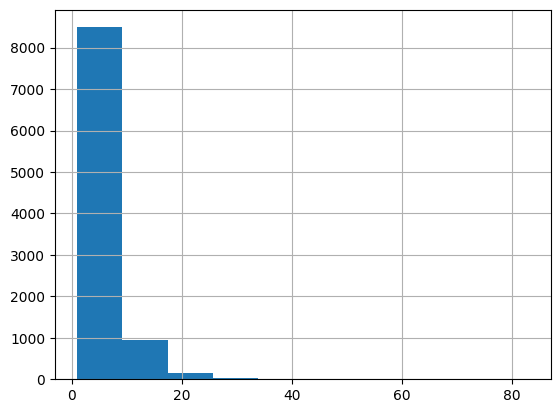

In [11]:
gdf["overlapping_cells"].apply(lambda x: len(x)).hist() # Visualizamos la cantidad de celdas que intersectan con cada poligono

In [12]:
(gdf["overlapping_cells"].apply(lambda x: len(x)) == 0).sum() #  Chequeamos que todos los poligonos intersecten con al menos una celda

np.int64(0)

Now we will invert the relationship, we want to build a dictionary with how much of each building there is in each cell.

In [13]:
# First we will get all the intersections:

intersections = gdf["overlapping_cells"].explode().reset_index(drop=True)
intersections = pd.DataFrame(intersections.tolist())
intersections["coordinates"] = "(" + intersections["x_cell"].astype(str) + " , " + intersections["y_cell"].astype(str) + ")"
intersections

,x_cell,y_cell,area,polygon_tag,coordinates
0,98,-69,3.463963e-10,48Q39JRG+3WRP,"(98 , -69)"
1,98,-68,6.770019e-09,48Q39JRG+3WRP,"(98 , -68)"
2,98,-67,5.084742e-09,48Q39JRG+3WRP,"(98 , -67)"
3,99,-69,3.942767e-11,48Q39JRG+3WRP,"(99 , -69)"
4,99,-68,8.556814e-10,48Q39JRG+3WRP,"(99 , -68)"
...,...,...,...,...,...
56820,-83,-88,6.369819e-10,48Q39JQ6+9936,"(-83 , -88)"
56821,-63,-51,1.118431e-09,48Q39JR7+P483,"(-63 , -51)"
56822,-63,-50,3.867853e-10,48Q39JR7+P483,"(-63 , -50)"
56823,-62,-51,3.595900e-10,48Q39JR7+P483,"(-62 , -51)"


In [14]:
# We will get the relative weight of each polygon in the cell
intersections["relative_weight"] = intersections["area"] / intersections.groupby("coordinates")["area"].transform("sum")
intersections

,x_cell,y_cell,area,polygon_tag,coordinates,relative_weight
0,98,-69,3.463963e-10,48Q39JRG+3WRP,"(98 , -69)",0.059825
1,98,-68,6.770019e-09,48Q39JRG+3WRP,"(98 , -68)",1.000000
2,98,-67,5.084742e-09,48Q39JRG+3WRP,"(98 , -67)",1.000000
3,99,-69,3.942767e-11,48Q39JRG+3WRP,"(99 , -69)",0.006861
4,99,-68,8.556814e-10,48Q39JRG+3WRP,"(99 , -68)",1.000000
...,...,...,...,...,...,...
56820,-83,-88,6.369819e-10,48Q39JQ6+9936,"(-83 , -88)",0.136004
56821,-63,-51,1.118431e-09,48Q39JR7+P483,"(-63 , -51)",0.601968
56822,-63,-50,3.867853e-10,48Q39JR7+P483,"(-63 , -50)",0.111643
56823,-62,-51,3.595900e-10,48Q39JR7+P483,"(-62 , -51)",0.283735


In [15]:
intersections[intersections["coordinates"] == "(98 , -69)"]

,x_cell,y_cell,area,polygon_tag,coordinates,relative_weight
0,98,-69,3.463963e-10,48Q39JRG+3WRP,"(98 , -69)",0.059825
16328,98,-69,5.443790e-09,48Q39JRG+2VXC,"(98 , -69)",0.940175


In [16]:
occupied_area = intersections.groupby(["x_cell", "y_cell"])["area"].sum().reset_index()
occupied_area

,x_cell,y_cell,area
0,-112,-112,7.893705e-12
1,-112,-111,9.507912e-10
2,-112,-110,6.805685e-10
3,-112,-109,3.127330e-10
4,-112,-108,1.662399e-09
...,...,...,...
35528,111,56,4.233188e-09
35529,111,90,2.207415e-09
35530,111,91,8.069630e-09
35531,111,92,6.859048e-09


In [17]:
# We will normalize by the cell size
occupied_area["normalized_area"] = occupied_area["area"] / (cell_size * cell_size)

In [18]:
# Now we will make a pivot table to get the area occupied by each polygon in each cell
occupied_area_heatmap = occupied_area.pivot_table(index="y_cell", columns="x_cell", values="area", aggfunc="sum", fill_value=0)
occupied_area_heatmap

x_cell,-112,-111,-110,-109,-108,-107,-106,-105,-104,-103,...,102,103,104,105,106,107,108,109,110,111
y_cell,,,,,,,,,,,,,,,,,,,,,
-112,7.893705e-12,9.410572e-12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
-111,9.507912e-10,7.991917e-09,6.878514e-09,4.975848e-09,7.403933e-09,1.074567e-09,6.899860e-09,6.011230e-09,0.000000e+00,1.110020e-09,...,3.183745e-12,0.000000e+00,1.032083e-12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
-110,6.805685e-10,8.056338e-09,4.312250e-09,5.886476e-09,5.052151e-09,1.566987e-09,5.383904e-09,3.077630e-09,5.418760e-11,2.010577e-09,...,3.068397e-09,1.886733e-09,3.515852e-09,7.083473e-09,4.323450e-09,3.387231e-13,0.000000e+00,3.892913e-09,1.077263e-09,0.000000e+00
-109,3.127330e-10,8.069630e-09,6.387527e-09,6.648976e-09,2.765349e-09,1.523866e-09,5.665125e-09,2.545198e-09,5.107415e-10,5.801682e-09,...,3.896169e-09,3.037610e-09,3.613623e-09,2.807859e-09,4.418409e-09,4.041302e-09,8.565459e-11,2.841899e-09,4.287879e-09,7.191937e-09
-108,1.662399e-09,6.438794e-09,3.086065e-09,7.411476e-09,8.250435e-10,1.390434e-09,5.327492e-09,3.908658e-09,0.000000e+00,2.168921e-09,...,5.194903e-09,5.136366e-09,1.475937e-09,3.667285e-09,6.148149e-09,6.816402e-09,0.000000e+00,5.356879e-10,4.962615e-09,8.053334e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.480201e-10,1.442744e-10,1.243103e-09,2.944768e-09,2.790494e-09,...,7.448641e-09,1.016296e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
108,0.000000e+00,0.000000e+00,3.478432e-10,4.069709e-09,1.775639e-09,3.983695e-09,5.252621e-09,8.069629e-09,7.744715e-09,4.773800e-09,...,8.069630e-09,6.536337e-09,3.112314e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
109,0.000000e+00,0.000000e+00,4.441406e-09,8.014125e-09,2.151107e-09,6.529145e-09,3.215800e-09,4.223970e-09,2.779301e-09,6.581824e-09,...,8.069630e-09,8.069630e-09,4.992688e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


<Axes: xlabel='x_cell', ylabel='y_cell'>

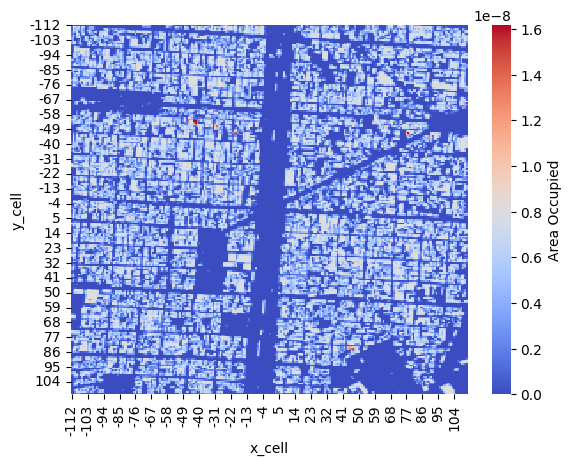

In [19]:
sns.heatmap(occupied_area_heatmap, cmap="coolwarm", cbar_kws={'label': 'Area Occupied'})

Now we will work on the orientation of the buildings process

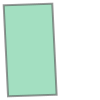

In [20]:
poly = gdf.iloc[0]["geometry"]
poly

In [21]:
%load_ext autoreload
%autoreload 2

In [22]:
import tools

In [23]:
tools.get_polygon_orientation(poly)

(92.72909721995279, np.float64(0.848511508446018))

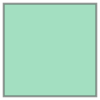

In [24]:
poly_grid[0][0]

In [25]:
tools.get_polygon_orientation(poly_grid[0][0])

(67.49997037597203, np.float64(1.057642916645382e-05))

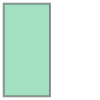

In [26]:
poly_grid[0][0].union(poly_grid[0][1])

In [27]:
tools.get_polygon_orientation(poly_grid[0][0].union(poly_grid[0][1]))

(89.99999999848936, np.float64(0.8660254037958554))

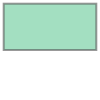

In [28]:
poly_grid[0][0].union(poly_grid[1][0])

In [29]:
tools.get_polygon_orientation(poly_grid[0][0].union(poly_grid[1][0]))

(7.553069281129865e-10, np.float64(0.8660254037787303))

We tested expected results with some exploration geometries. We have discovered that we need to exclude the last point on the polygon algorithm to avoid bias due the repetition of the first point on the closing of the polygon. 

We need now to solve the problem of how to merge many buildings on the same cell and calculate an aggregated orientation. A simple way to do this is just to add to the algorithm that calculate one polygon orientation based on the list of points of single polygon all the point from all the polygons and then calculate the orientation of the resulting conjunction of points. 

We need to have some precautions on this addition of point to avoid weight incorrectly each polygon. We need to weight each polygon by the fraction of the polygon that is in fact on the cell. Also we need to standardize the weight of each polygon according to the number of points of the polygon. 

Note: On previous code that I am dropping now I worked with the idea os use just the PCA for get the orientation of the polygons, but at the moment of combine many polygons I found many limitations on that approach. So, now I am using a combination of the minimum_rotated_rectangle built-in function that found the rectangle that contains all the points of the polygon and then PCA for the orientation of the rectangle. This also prevents to have bias if a polygon is not homogeneous on the density of points on it border (for example a curvy side could have a lot of points that will bias the orientation on PCA just using the points).

In [30]:
# We will test the new code on the same polygons

poly1 = poly_grid[0][0].union(poly_grid[0][1])
poly2 = poly_grid[0][0].union(poly_grid[1][0])

tools.get_orientation_for_many_polygons([poly1, poly2]) # We see that the module is almost zero

(67.50002534731534, np.float64(8.192488487582812e-06))

In [31]:
tools.get_orientation_for_many_polygons([poly1, poly2], [1,0]) # We see that the angle is almost 90 degrees

(89.99999999848936, np.float64(0.8660254037958554))

In [32]:
tools.get_orientation_for_many_polygons([poly1, poly2], [0,1]) # We see that the angle is almost 0 degrees

(7.553069281129865e-10, np.float64(0.8660254037787303))

In [ ]:
tools.get_orientation_for_many_polygons([poly1, poly2], [1,0.5]) # We see that the angle is almost 90 degrees

(89.99999999773402, np.float64(0.7276068751281828))

In [38]:
tools.get_orientation_for_many_polygons([poly1, poly2], [1,0.9]) # We see that the angle is almost 90 degrees

(89.99999998882912, np.float64(0.34424281916432603))

We need to keep in mind that with high symmetry polygons the orientation is very sensitive to the noise. 

We wil use this codes to calculate the orientation of the polygons:

In [39]:
# First we add the vector to the dataframe
gdf["vector_orientation"] = gdf["geometry"].progress_apply(tools.get_polygon_orientation)

gdf

100%|██████████| 9632/9632 [00:01<00:00, 6027.06it/s]


,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code,relative_lat,relative_lon,cell_lat,cell_lon,cells_size,overlapping_cells,vector_orientation
0,-34.609757,-58.372732,137.1630,0.7771,"POLYGON ((-58.37269 -34.60983, -58.37269 -34.6...",48Q39JRG+3WRP,-0.006034,0.008859,-68,98,1,"[{'x_cell': 98, 'y_cell': -69, 'area': 3.46396...","(92.72909721995279, 0.848511508446018)"
1,-34.603312,-58.388291,23.7655,0.6978,"POLYGON ((-58.38826 -34.60333, -58.38827 -34.6...",48Q39JW6+MMGG,0.000411,-0.006699,4,-75,1,"[{'x_cell': -75, 'y_cell': 4, 'area': 2.335188...","(3.4612145784253414, 0.6286458606100553)"
2,-34.606673,-58.383463,214.7212,0.7673,"POLYGON ((-58.38343 -34.60678, -58.38343 -34.6...",48Q39JV8+8JM2,-0.002950,-0.001872,-33,-21,2,"[{'x_cell': -22, 'y_cell': -35, 'area': 2.2529...","(91.46331219263188, 0.5469781892418375)"
3,-34.606241,-58.379755,218.6224,0.8731,"POLYGON ((-58.37969 -34.60634, -58.37972 -34.6...",48Q39JVC+G359,-0.002518,0.001837,-29,20,2,"[{'x_cell': 19, 'y_cell': -30, 'area': 5.91693...","(95.95203507903008, 0.888419048499807)"
4,-34.601788,-58.372265,140.9480,0.7562,"POLYGON ((-58.37218 -34.60183, -58.37219 -34.6...",48Q39JXH+73QG,0.001935,0.009326,21,103,1,"[{'x_cell': 102, 'y_cell': 21, 'area': 6.36596...","(2.7448755038479646, 0.8564655576439201)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9627,-34.612691,-58.378285,99.3895,0.8269,"POLYGON ((-58.37821 -34.61272, -58.37821 -34.6...",48Q39JPC+WMG9,-0.008969,0.003307,-100,36,1,"[{'x_cell': 35, 'y_cell': -100, 'area': 2.7939...","(2.8860868925709156, 0.8881545781031652)"
9628,-34.598224,-58.387981,197.2301,0.7845,"POLYGON ((-58.38791 -34.59828, -58.38792 -34.5...",48Q3CJ26+PR64,0.005499,-0.006390,61,-72,2,"[{'x_cell': -73, 'y_cell': 60, 'area': 8.03593...","(2.717466035734276, 0.8026168800888288)"
9629,-34.600833,-58.380258,37.6236,0.6620,"POLYGON ((-58.38022 -34.60086, -58.38023 -34.6...",48Q39JX9+MV9Q,0.002890,0.001334,32,14,1,"[{'x_cell': 14, 'y_cell': 31, 'area': 6.322612...","(2.3332059539953036, 0.33374517668908427)"
9630,-34.611618,-58.389089,76.9883,0.7808,"POLYGON ((-58.38903 -34.61165, -58.38903 -34.6...",48Q39JQ6+9936,-0.007896,-0.007498,-88,-84,1,"[{'x_cell': -85, 'y_cell': -89, 'area': 1.8715...","(1.0707168086603076, 0.8054254071100247)"


We could check with the added modification that results are very similar to the legacy results.

In [ ]:
# First we add the vector to the dataframe
#gdf["vector_orientation"] = gdf["geometry"].progress_apply(tools.get_polygon_orientation)

#gdf

  0%|          | 0/9632 [00:00<?, ?it/s]

100%|██████████| 9632/9632 [00:01<00:00, 8406.20it/s]


,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code,relative_lat,relative_lon,cell_lat,cell_lon,cells_size,overlapping_cells,vector
0,-34.609757,-58.372732,137.1630,0.7771,"POLYGON ((-58.37269 -34.60983, -58.37269 -34.6...",48Q39JRG+3WRP,-0.006034,0.008859,-68,98,1,"[{'x_cell': 98, 'y_cell': -69, 'area': 3.46396...","(93.07223470644678, 0.8458763569749824)"
1,-34.603312,-58.388291,23.7655,0.6978,"POLYGON ((-58.38826 -34.60333, -58.38827 -34.6...",48Q39JW6+MMGG,0.000411,-0.006699,4,-75,1,"[{'x_cell': -75, 'y_cell': 4, 'area': 2.335188...","(0.7360455471056184, 0.6081212578452938)"
2,-34.606673,-58.383463,214.7212,0.7673,"POLYGON ((-58.38343 -34.60678, -58.38343 -34.6...",48Q39JV8+8JM2,-0.002950,-0.001872,-33,-21,2,"[{'x_cell': -22, 'y_cell': -35, 'area': 2.2529...","(63.89787217348065, 0.7340107347159496)"
3,-34.606241,-58.379755,218.6224,0.8731,"POLYGON ((-58.37969 -34.60634, -58.37972 -34.6...",48Q39JVC+G359,-0.002518,0.001837,-29,20,2,"[{'x_cell': 19, 'y_cell': -30, 'area': 5.91693...","(96.47229285889776, 0.88483857771671)"
4,-34.601788,-58.372265,140.9480,0.7562,"POLYGON ((-58.37218 -34.60183, -58.37219 -34.6...",48Q39JXH+73QG,0.001935,0.009326,21,103,1,"[{'x_cell': 102, 'y_cell': 21, 'area': 6.36596...","(2.270273890741265, 0.8529048969625799)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9627,-34.612691,-58.378285,99.3895,0.8269,"POLYGON ((-58.37821 -34.61272, -58.37821 -34.6...",48Q39JPC+WMG9,-0.008969,0.003307,-100,36,1,"[{'x_cell': 35, 'y_cell': -100, 'area': 2.7939...","(2.5091082051372666, 0.8855336705921899)"
9628,-34.598224,-58.387981,197.2301,0.7845,"POLYGON ((-58.38791 -34.59828, -58.38792 -34.5...",48Q3CJ26+PR64,0.005499,-0.006390,61,-72,2,"[{'x_cell': -73, 'y_cell': 60, 'area': 8.03593...","(176.17566933813166, 0.8134468711303796)"
9629,-34.600833,-58.380258,37.6236,0.6620,"POLYGON ((-58.38022 -34.60086, -58.38023 -34.6...",48Q39JX9+MV9Q,0.002890,0.001334,32,14,1,"[{'x_cell': 14, 'y_cell': 31, 'area': 6.322612...","(170.5456567347141, 0.29367307265676806)"
9630,-34.611618,-58.389089,76.9883,0.7808,"POLYGON ((-58.38903 -34.61165, -58.38903 -34.6...",48Q39JQ6+9936,-0.007896,-0.007498,-88,-84,1,"[{'x_cell': -85, 'y_cell': -89, 'area': 1.8715...","(0.798134803623185, 0.8031876903520745)"


In [42]:
# Now we want again to build the information for each cell. We remember that we have the intersection dataframe that indicate for each cell how much of each building there is inside. 
intersections

,x_cell,y_cell,area,polygon_tag,coordinates,relative_weight
0,98,-69,3.463963e-10,48Q39JRG+3WRP,"(98 , -69)",0.059825
1,98,-68,6.770019e-09,48Q39JRG+3WRP,"(98 , -68)",1.000000
2,98,-67,5.084742e-09,48Q39JRG+3WRP,"(98 , -67)",1.000000
3,99,-69,3.942767e-11,48Q39JRG+3WRP,"(99 , -69)",0.006861
4,99,-68,8.556814e-10,48Q39JRG+3WRP,"(99 , -68)",1.000000
...,...,...,...,...,...,...
56820,-83,-88,6.369819e-10,48Q39JQ6+9936,"(-83 , -88)",0.136004
56821,-63,-51,1.118431e-09,48Q39JR7+P483,"(-63 , -51)",0.601968
56822,-63,-50,3.867853e-10,48Q39JR7+P483,"(-63 , -50)",0.111643
56823,-62,-51,3.595900e-10,48Q39JR7+P483,"(-62 , -51)",0.283735


In [43]:
# We remember that relative_weight is the relative weight of each polygon in the cell
intersections[(intersections["x_cell"] == 98) & (intersections["y_cell"] == -69)]

,x_cell,y_cell,area,polygon_tag,coordinates,relative_weight
0,98,-69,3.463963e-10,48Q39JRG+3WRP,"(98 , -69)",0.059825
16328,98,-69,5.443790e-09,48Q39JRG+2VXC,"(98 , -69)",0.940175


In [44]:
# We will rename the columns of the intersections dataframe to make it easier to work with the actual tools codes
intersections = intersections.rename(columns={"x_cell": "cell_long_pos", "y_cell": "cell_lat_pos", "polygon_tag": "polygon_tag", "area": "area", "relative_weight": "relative_weight", "coordinates": "coordinates"})

In [45]:
cell_composition = tools.build_cell_composition(intersections)
cell_composition

cell_composition
cell_long_pos cell_lat_pos                                                   
-112          -112          [{'polygon_tag': '48Q39JP5+GCRV', 'relative_we...
              -111          [{'polygon_tag': '48Q39JP5+GCRV', 'relative_we...
              -110          [{'polygon_tag': '48Q39JP5+JC2G', 'relative_we...
              -109          [{'polygon_tag': '48Q39JP5+J9XG', 'relative_we...
              -108          [{'polygon_tag': '48Q39JP5+J9XG', 'relative_we...
...                                                                       ...
 111           56           [{'polygon_tag': '48Q3CJ2H+G92Q', 'relative_we...
               90           [{'polygon_tag': '48Q3CJ3H+R89P', 'relative_we...
               91           [{'polygon_tag': '48Q3CJ3H+R89P', 'relative_we...
               92           [{'polygon_tag': '48Q3CJ3H+R89P', 'relative_we...
               93           [{'polygon_tag': '48Q3CJ3H+R89P', 'relative_we...

[35533 rows x 1 columns]

In [46]:
cell_composition.loc[98,-69]["cell_composition"]

[{'polygon_tag': '48Q39JRG+3WRP', 'relative_weight': 0.05982473253742929},
 {'polygon_tag': '48Q39JRG+2VXC', 'relative_weight': 0.9401752674625707}]

In [ ]:
# With this information we could use the code that combines many polygons on the same cell. We will apply for each one the weight that has in the cell the area of that building, but first we need to found the fraction not for the area of a building inside the cell over the total area on the cell. We need to fraction of the area inside the cell related with the total area of the building. 

In [47]:
cell_composition["cell_composition"]

cell_long_pos  cell_lat_pos
-112           -112            [{'polygon_tag': '48Q39JP5+GCRV', 'relative_we...
               -111            [{'polygon_tag': '48Q39JP5+GCRV', 'relative_we...
               -110            [{'polygon_tag': '48Q39JP5+JC2G', 'relative_we...
               -109            [{'polygon_tag': '48Q39JP5+J9XG', 'relative_we...
               -108            [{'polygon_tag': '48Q39JP5+J9XG', 'relative_we...
                                                     ...                        
 111            56             [{'polygon_tag': '48Q3CJ2H+G92Q', 'relative_we...
                90             [{'polygon_tag': '48Q3CJ3H+R89P', 'relative_we...
                91             [{'polygon_tag': '48Q3CJ3H+R89P', 'relative_we...
                92             [{'polygon_tag': '48Q3CJ3H+R89P', 'relative_we...
                93             [{'polygon_tag': '48Q3CJ3H+R89P', 'relative_we...
Name: cell_composition, Length: 35533, dtype: object